# Script used to perform regression, trying to predict the number of attacks per state, per year.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import *

sc = pyspark.SparkContext(appName="Pi")
spark = SparkSession(sc)

### Dataset aquisition
The <strong>original</strong> number of rows of this dataset (before some NaNs cleaning) is given by:<br>
number of countries (~250) * number of years from 1960 to 2018 (~60)<br>
This number could be subjected to relevent growth if, for example, the records are represented day by day, instead of year by year: this would mean we'd get 365 records, for each country, <strong>for each year</strong> since 1960.<br>
About the NaNs' cleaning, it is a sort of filtering of which we can't know the exact outcome's dimension: it would be riskful to make assumptions.<br>
It's reasonable to consider the scalability of the dataset we're going to read.

In [77]:
df = pd.read_csv('./part/DF1sthypTOT') #just used to show the outlook of our dataset
sdf = spark.read.csv("./part/DF1sthypTOT", inferSchema = True, header = True)

In [49]:
df.head()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Area (sq. mi.),Population,Density,cnt
0,604.5970,51.276,AFG,1960,32.328512,4.000000e+07,739462.0,8255331.0,551.1210,2.252607e+10,647500.0,31056997.0,13.891572,0.0
1,160.4806,42.240,ALB,1960,62.254366,6.200000e+07,493982.0,1114818.0,151.0588,2.252607e+10,28748.0,3581655.0,55.962154,0.0
2,373.1320,49.671,DZA,1960,46.135122,1.451501e+09,3394205.0,7730687.0,323.2800,2.252607e+10,2381740.0,32930091.0,4.670910,0.0
3,565.4100,54.423,AGO,1960,32.984829,1.451501e+09,550013.0,4720831.0,500.8860,2.252607e+10,1246700.0,12127071.0,4.227837,0.0
4,255.1080,23.682,ARG,1960,65.215537,1.030000e+08,15177907.0,5441168.0,156.2470,2.252607e+10,2766890.0,39921833.0,7.452076,0.0


In [78]:
sdf = sdf.drop('CountryCode')
del df['CountryCode']

#### Let's define two metrics that we'll adopt
- TerritoryDefense: MilitaryExp / Area (sq. mi.)
- PopulationDefense: MS.MIL.MPRT.KD / Population

(Let's remind that "MS.MIL.MPRT.KD" is the arms import)

In [79]:
# Pandas implementation

df["TerritoryDefense"]= df['MilitaryExp'] / df['Area (sq. mi.)']
df["PopulationDefense"] = df['MS.MIL.MPRT.KD'] / df['Population']

del df["Area (sq. mi.)"]
df.head()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Population,Density,cnt,TerritoryDefense,PopulationDefense
0,604.5970,51.276,1960,32.328512,4.000000e+07,739462.0,8255331.0,551.1210,2.252607e+10,31056997.0,13.891572,0.0,34789.294798,1.287955
1,160.4806,42.240,1960,62.254366,6.200000e+07,493982.0,1114818.0,151.0588,2.252607e+10,3581655.0,55.962154,0.0,783569.931176,17.310433
2,373.1320,49.671,1960,46.135122,1.451501e+09,3394205.0,7730687.0,323.2800,2.252607e+10,32930091.0,4.670910,0.0,9457.820073,44.078259
3,565.4100,54.423,1960,32.984829,1.451501e+09,550013.0,4720831.0,500.8860,2.252607e+10,12127071.0,4.227837,0.0,18068.555692,119.690985
4,255.1080,23.682,1960,65.215537,1.030000e+08,15177907.0,5441168.0,156.2470,2.252607e+10,39921833.0,7.452076,0.0,8141.295238,2.580042


In [81]:
#Spark implementation

from pyspark.sql.functions import lit

sdf = sdf.withColumn("TerritoryDefense", sdf['MilitaryExp'] / sdf['`Area (sq. mi.)`'])
sdf = sdf.withColumn("PopulationDefense", sdf['`MS.MIL.MPRT.KD`'] / sdf['Population'])

sdf2 = sdf.drop("Area (sq. mi.)")
#sdf3 = sdf2.drop('Population')
sdf2.show(5)

+------------------+-----------------+----+------------------+--------------------+-----------+-----------+------------------+--------------------+-----------+------------------+---+------------------+------------------+
|    SP.DYN.AMRT.MA|   SP.DYN.CBRT.IN|Year|    SP.DYN.LE00.IN|      MS.MIL.MPRT.KD|SP.URB.TOTL|SP.RUR.TOTL|    SP.DYN.AMRT.FE|         MilitaryExp| Population|           Density|cnt|  TerritoryDefense| PopulationDefense|
+------------------+-----------------+----+------------------+--------------------+-----------+-----------+------------------+--------------------+-----------+------------------+---+------------------+------------------+
|           604.597|           51.276|1960|   32.328512195122|               4.0E7|   739462.0|  8255331.0|           551.121|2.252606838145494E10|3.1056997E7|13.891572200772199|0.0| 34789.29479761381|1.2879545308260165|
|          160.4806|            42.24|1960|62.254365853658506|               6.2E7|   493982.0|  1114818.0|         

In [82]:
sdf = sdf2
sdf.dtypes

[('SP.DYN.AMRT.MA', 'double'),
 ('SP.DYN.CBRT.IN', 'double'),
 ('Year', 'int'),
 ('SP.DYN.LE00.IN', 'double'),
 ('MS.MIL.MPRT.KD', 'double'),
 ('SP.URB.TOTL', 'double'),
 ('SP.RUR.TOTL', 'double'),
 ('SP.DYN.AMRT.FE', 'double'),
 ('MilitaryExp', 'double'),
 ('Population', 'double'),
 ('Density', 'double'),
 ('cnt', 'double'),
 ('TerritoryDefense', 'double'),
 ('PopulationDefense', 'double')]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03985d5898>,
      dtype=object)

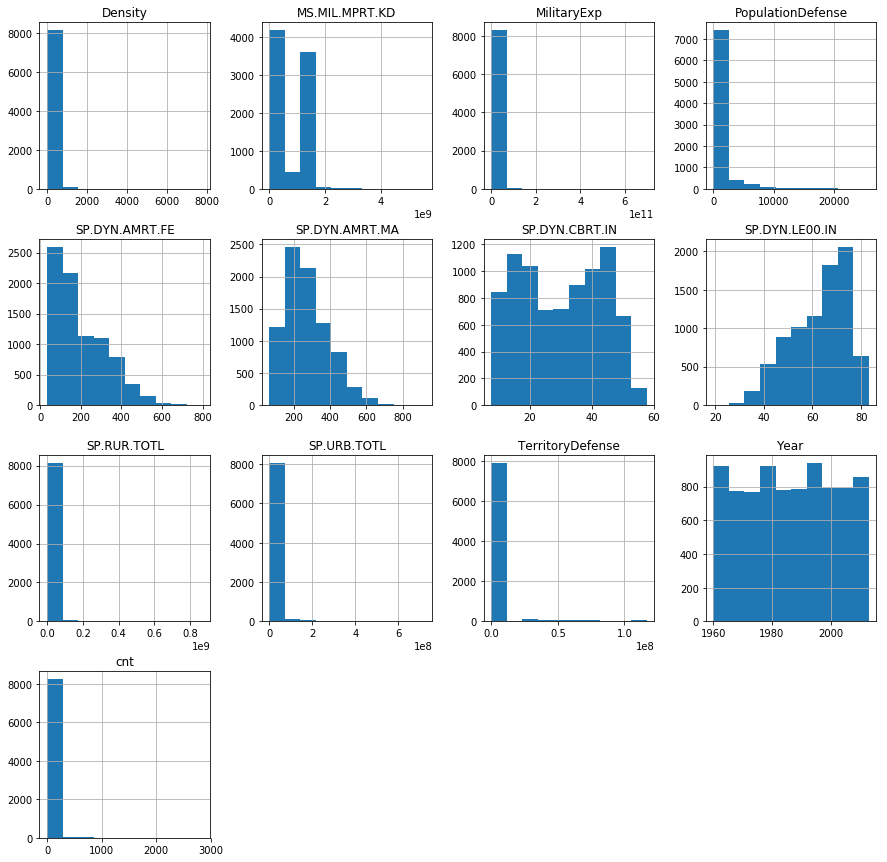

In [9]:
df.hist(figsize=(15,15))

In [83]:
df_std = df 

print('Shape of the df: ', sdf.count(), len(sdf.columns) + 1)
print('Number of cnt = 0: ', sdf[sdf['cnt'] == 0].count())

Shape of the df:  8332 15
Number of cnt = 0:  5526


#### We had a lot of values of cnt equal to zero. So we decided to delete all of them, focusing more on the other values of cnt.

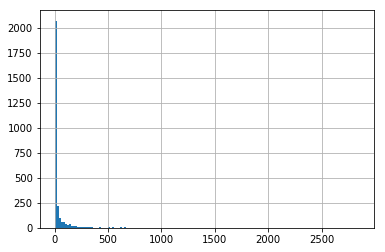

In [84]:
df_std = df_std[df_std['cnt'] > 0]
df_std['cnt'].hist(bins=150)

In [85]:
sdf = sdf.drop('cnt2')
sdf = sdf.filter(sdf.cnt > 0)
print('Number of remaining samples: ',sdf[sdf['cnt'] > 0].count())

Number of remaining samples:  2806


In [86]:
print('Shape of the df: ', df_std.shape)

Shape of the df:  (2806, 14)


### Multicollinearity handling
We want to use the <strong>heatmap visual tool</strong> to study the multicollinearity, which works with pandas dataframes.<br>
So, since it may end up in a complex computation, we decided to explicitely control the size of the dataframe.<br>
We are taking into account the last century, which is a range wide enough to be representative.<br>
Notice that, in our case, we're still considering the whole dataset, since it has a range of about 50 years; but this solution takes into account a possible scalability of the dataset.<br>
We could have achieved the same task using Spark and other tools, but remember that using resources thoughtlessly means that we're wasting money.

In [87]:
years_range = 100
year = df_std['Year'].max() - years_range
df_std = df_std[df_std['Year'] > year]

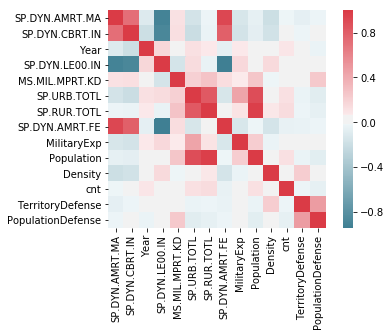

In [88]:
corr = df_std.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True), square=True)

In [89]:
del df_std['SP.URB.TOTL']
del df_std['SP.RUR.TOTL']
del df_std['SP.DYN.AMRT.FE']
del df_std['SP.DYN.AMRT.MA']
del df_std['SP.DYN.LE00.IN']

#we deleted them because of collinearity.


In [90]:
del df_std['MilitaryExp']
del df_std['MS.MIL.MPRT.KD']

In [91]:
#We do the same on Spark df

sdf = sdf.drop('SP.URB.TOTL')
sdf = sdf.drop('SP.RUR.TOTL')
sdf = sdf.drop('SP.DYN.AMRT.FE')
sdf = sdf.drop('SP.DYN.AMRT.MA')
sdf = sdf.drop('SP.DYN.LE00.IN')
sdf = sdf.drop('MilitaryExp')
sdf = sdf.drop('MS.MIL.MPRT.KD')

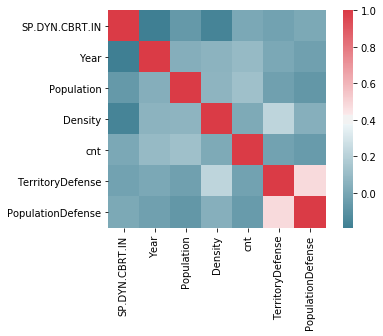

In [92]:
corr = df_std.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True), square=True)

In [93]:
from sklearn.model_selection import train_test_split

feature_matrix = df_std.loc[:, df_std.columns != 'cnt']
target_vector = df_std.cnt

x_train, x_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

In [94]:
x_train.shape

(2244, 6)

In [95]:
x_test.shape

(562, 6)

Let's prepare also the Spark dataset:

In [96]:
feature_columns = sdf.columns[0:10] + sdf.columns[11:-1]
feature_columns

['SP.DYN.CBRT.IN',
 'Year',
 'Population',
 'Density',
 'cnt',
 'TerritoryDefense',
 'PopulationDefense']

In [97]:
sdf = sdf.withColumnRenamed("SP.DYN.CBRT.IN", "BirthRate")

feature_columns = sdf.columns[0:4] + sdf.columns[5:-1]
feature_columns

['BirthRate', 'Year', 'Population', 'Density', 'TerritoryDefense']

In [98]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [99]:
sdf_features = assembler.transform(sdf)
sdf_features.show(5)

+---------+----+------------+------------------+----+------------------+-------------------+--------------------+
|BirthRate|Year|  Population|           Density| cnt|  TerritoryDefense|  PopulationDefense|            features|
+---------+----+------------+------------------+----+------------------+-------------------+--------------------+
|   22.759|1970| 3.9921833E7| 8.664262764331072|21.0|161.08840391197336|  6.337384358077947|[22.759,1970.0,3....|
|     20.6|1970| 2.0264082E7|1.6270644021933562| 1.0|166.17472748915355| 11.843615713754021|[20.6,1970.0,2.02...|
|     14.7|1970| 1.0379067E7|  316.285017033543| 1.0|  24494.0739288522|  50.87162458822166|[14.7,1970.0,1.03...|
|   42.261|1970|   8989046.0| 4.101452784503632| 1.0|15.280758734002076|0.22249302095016535|[42.261,1970.0,89...|
|   35.214|1970|1.88078227E8|11.276180411926036| 6.0|120.56374456426924|  1.164409105153889|[35.214,1970.0,1....|
+---------+----+------------+------------------+----+------------------+----------------

In [100]:
from pyspark.ml.regression import LinearRegression

train, test = sdf_features.randomSplit([0.8, 0.2])

In [101]:
algorithm = LinearRegression(featuresCol="features", labelCol="cnt")
sdf_model = algorithm.fit(train)

Let's proceed to see how the model works on the training set

In [102]:
trainingSummary = sdf_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(10)
print("R2: %f" % trainingSummary.r2)

numIterations: 1
objectiveHistory: [0.0]
+-------------------+
|          residuals|
+-------------------+
|-30.408402156924694|
|-31.170687196786275|
|-30.821863422691422|
|  -33.6760101739801|
| -39.95238976634482|
|-34.897286279137916|
|-50.928612273608906|
|-48.591150613337504|
| -48.35287537553813|
| -52.17244596217006|
+-------------------+
only showing top 10 rows

R2: 0.022807


Now let's check the test set:

In [103]:
evaluation_summary = sdf_model.evaluate(test)
print("MAE",evaluation_summary.meanAbsoluteError)
print("RMSE",evaluation_summary.rootMeanSquaredError)
print("R2",evaluation_summary.r2)

MAE 53.79036998616541
RMSE 104.94223247276813
R2 0.03936767499216132


We performed the scaling, using the mean-variance scaling.

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale

x_train = pd.DataFrame(scale(x_train), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(scale(x_test), index=x_test.index, columns=x_test.columns)
model=LinearRegression(fit_intercept=True)
model.fit(x_train,y_train)

LinearRegression()

In [105]:
y_pred_train = model.predict(x_train)

In [106]:
y_pred_test = model.predict(x_test)

In [260]:
from sklearn import metrics

R2_base = metrics.r2_score(y_train, y_pred_train, sample_weight=None, multioutput='uniform_average')
R2 = metrics.r2_score(y_test, y_pred_test, sample_weight=None, multioutput='uniform_average')

print("R2 on train: ", R2_base)
print("R2 on test: ", R2)

R2 on train:  -0.9856328674322796
R2 on test:  -1.1131367792498597


In [264]:
#statistical testings of LinearRegression  
import statsmodels.api as sm 
from scipy import stats 

est = sm.OLS(y_train, x_train) 
est2 = est.fit() 
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     574.4
Date:                Sun, 08 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:05:31   Log-Likelihood:                -2647.5
No. Observations:                2244   AIC:                             5307.
Df Residuals:                    2238   BIC:                             5341.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
SP.DYN.CBRT.IN       -0.0034      0.00

In [108]:
coefficients = pd.Series(model.coef_, index=x_train.columns)
print('Coefficients: ')
print(coefficients)

Coefficients: 
SP.DYN.CBRT.IN        4.932860
Year                 12.940231
Population           16.388321
Density               2.139197
TerritoryDefense     -0.696271
PopulationDefense    -5.555010
dtype: float64


The results using the regression are so bad, so we tried with a polynomial model.

## Polynomial models applying k-Fold CV and Ridge regularization

In [109]:
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures as pol
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from statistics import mean 
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=5, shuffle=True, random_state=2) # we are setting 7 folds
feature_matrix=df_std.loc[:, df_std.columns != 'cnt']
target_vector=df_std['cnt']
MSE_tr, MSE_te = [], []
R2_tr, R2_te = [], []
kMSE_tr, kMSE_te = [],  []
kR2_tr, kR2_te = [], []
degrees = [1,2,3,4] # list of different degrees of freedom
for degree in degrees: # cycle which applies the different degrees of freedom
    for train_index, test_index in kf.split(feature_matrix): # cycle that performs KCV on a certain polynomial model
        x_train, x_test = feature_matrix.iloc[train_index], feature_matrix.iloc[test_index]
        y_train, y_test = target_vector.iloc[train_index], target_vector.iloc[test_index]

        x_train = pd.DataFrame(scale(x_train), index=x_train.index, columns=x_train.columns) # standardization
        #y_train = pd.DataFrame(scale(y_train), index=y_train.index).to_numpy() # standardization
        x_test = pd.DataFrame(scale(x_test), index=x_test.index, columns=x_test.columns) # standardization
        #y_test = pd.DataFrame(scale(y_test), index=y_test.index).to_numpy() # standardization

        model = make_pipeline(pol(degree), RidgeCV(alphas=(0.01,1.0,100), cv=4))
        x = model.fit(x_train, y_train.ravel())
        y_pred_on_training=model.predict(x_train)
        y_pred=model.predict(x_test)
        MSE_tr.append(metrics.mean_squared_error(y_train, y_pred_on_training, sample_weight=None, multioutput='uniform_average'))
        MSE_te.append(metrics.mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average'))
        R2_tr.append(metrics.r2_score(y_train, y_pred_on_training, sample_weight=None, multioutput='uniform_average'))
        R2_te.append(metrics.r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average'))
    kMSE_tr.append(mean(MSE_tr))
    kMSE_te.append(mean(MSE_te))
    kR2_tr.append(mean(R2_tr))
    kR2_te.append(mean(R2_te))
    MSE_tr = []
    MSE_te = []
    R2_tr = []
    R2_te = []
print('kMSE on training, from degree 1 to 4:\n', kMSE_tr)
print('\nkMSE on testing, from degree 1 to 4:\n', kMSE_te)
print('\nkR2 on training, from degree 1 to 4:\n', kR2_tr)
print('\nkR2 on testing, from degree 1 to 4:\n', kR2_te)

kMSE on training, from degree 1 to 4:
 [17295.653619016928, 16185.198412152542, 14962.502659294267, 14176.11493600778]

kMSE on testing, from degree 1 to 4:
 [17335.938788519867, 16560.433956456618, 17920.686172708793, 402792.1693500129]

kR2 on training, from degree 1 to 4:
 [0.02679371574902769, 0.08931894133410243, 0.15817841169699648, 0.20270822750190057]

kR2 on testing, from degree 1 to 4:
 [0.022081747604760872, 0.0604609907918916, -0.03633485252653719, -30.91360314793772]


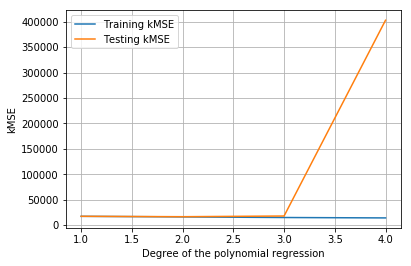

In [110]:
plt.plot(degrees, kMSE_tr, label='Training kMSE')
plt.plot(degrees, kMSE_te, label='Testing kMSE')
plt.xlabel('Degree of the polynomial regression')
plt.ylabel('kMSE')
plt.legend()
plt.grid()

plt.show()

In [ ]:
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import Ridge
#import yellowbrick
#from yellowbrick.regressor import ResidualsPlot

#model = make_pipeline(pol(2), RidgeCV(alphas=(0.01,1.0,100), cv=4))

# Instantiate the linear model and visualizer

#visualizer = ResidualsPlot(model)

#visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
#visualizer.score(x_test, y_test)  # Evaluate the model on the test data
#visualizer.show()                 # Finalize and render the figure

The best model was the polynomial with grade 3, resulting in a R2train = 0,30 and a R2test = 0,25. The results are still bad, so we decided to re-formulate the problem, passing to a classification problem.

In [111]:
df_class = df_std.rename(columns={'cnt':'conto'})

#### We are going to divide the data in 3 groups. 

Low number of attacks: 0 < cnt < 3

Medium number of attacks: 3 <= cnt < 15

High number of attacks: cnt >= 15

The splitting was made considering the fact that each cathegory had to be a good amount of sample.

In [200]:
df_class.groupby(by='conto').aggregate({'conto':'count'})

df_class['conto'] = df_class['conto'].apply(lambda x: 0 if (x > 0 and x < 3) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: -1 if (x >= 3 and x < 15) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: -2 if (x >= 15) else x)

df_class['conto'] = df_class['conto'].apply(lambda x: 1 if (x == -1) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: 2 if (x == -2) else x)

df_class = df_class.rename(columns={'conto':'cnt'})

df_class.head(10)

KeyError: 'conto'

Here we can see that each class has a good amount of samples.

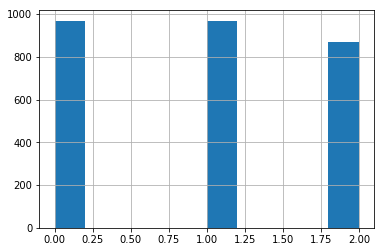

In [113]:
df_class.cnt.hist()

We can convert this pandas dataframe into a <strong>spark dataframe</strong>:

In [114]:
from pyspark.sql.types import *

mySchema = StructType([
  StructField("BirthRate", DoubleType(), True)
 ,StructField("Year", IntegerType(), True)
 ,StructField("UrbanPop", DoubleType(), True)
 ,StructField("Density", DoubleType(), True)
 ,StructField("cnt", DoubleType(), True)
 ,StructField("TerritoryDefense", DoubleType(), True)
 ,StructField("PopulationDefense", DoubleType(), True)])

sdf_class = spark.createDataFrame(df_class, schema=mySchema)
type(sdf_class)

pyspark.sql.dataframe.DataFrame

In [115]:
sdf_class.show(5)

+---------+----+------------+------------------+---+------------------+-------------------+
|BirthRate|Year|    UrbanPop|           Density|cnt|  TerritoryDefense|  PopulationDefense|
+---------+----+------------+------------------+---+------------------+-------------------+
|   22.759|1970| 3.9921833E7| 8.664262764331072|2.0|161.08840391197336|  6.337384358077947|
|     20.6|1970| 2.0264082E7|1.6270644021933562|0.0|166.17472748915355| 11.843615713754021|
|     14.7|1970| 1.0379067E7|  316.285017033543|0.0|  24494.0739288522|  50.87162458822166|
|   42.261|1970|   8989046.0| 4.101452784503632|0.0|15.280758734002076|0.22249302095016535|
|   35.214|1970|1.88078227E8|11.276180411926036|1.0|120.56374456426924|  1.164409105153889|
+---------+----+------------+------------------+---+------------------+-------------------+
only showing top 5 rows



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f038f432080>,
      dtype=object)

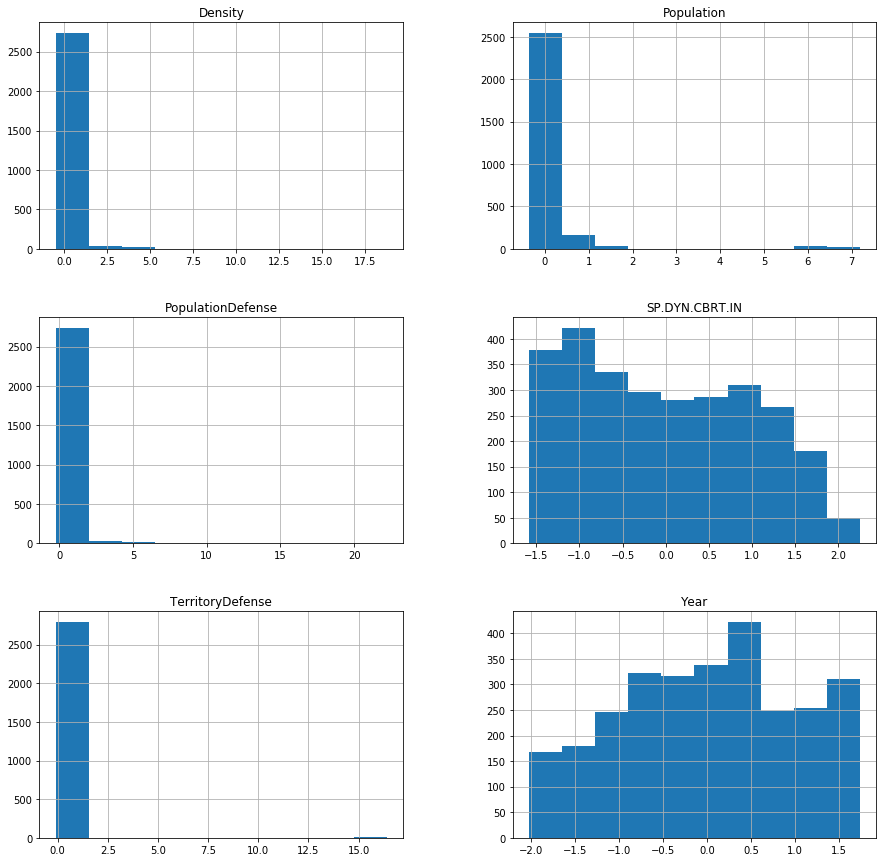

In [116]:
from sklearn.preprocessing import scale

feature_matrix=df_class.loc[:, df_std.columns != 'cnt']
target_vector=df_class['cnt']
feature_matrix = pd.DataFrame(scale(feature_matrix), index=feature_matrix.index, columns=feature_matrix.columns) # standardization
feature_matrix.hist(figsize=(15,15))

In [117]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

We first try with <strong>multinomial logistic regression</strong>.

In [118]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True,random_state=1, max_iter=10000, multi_class='multinomial',solver ='newton-cg').fit(x_train, y_train)
clf.predict(x_train)
print(clf.score(x_train,y_train))

clf.predict(x_test)
print(clf.score(x_test,y_test))

0.4229055258467023
0.3914590747330961


After we try with <strong>multi-layer perceptron</strong>.

In [119]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

clf = MLPClassifier(random_state=1, max_iter=1000)
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
print('train accuracy: ', accuracy_score(y_train, y_pred_train))

y_pred_test = clf.predict(x_test)
print('test accuracy: ', accuracy_score(y_test, y_pred_test))

train accuracy:  0.6029411764705882
test accuracy:  0.5871886120996441


Let's have a look to the <strong>confusion matrices</strong> for both training and testing set.

In [120]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred_train)

array([[463, 251,  55],
       [248, 416, 125],
       [ 56, 156, 474]])

In [122]:
confusion_matrix(y_test, y_pred_test)

array([[117,  70,  13],
       [ 52,  90,  38],
       [ 10,  49, 123]])

Finally, let's check how does it work a <strong>decision tree</strong>, to eventually have a model more easy to interpret:

In [123]:
from sklearn import tree
from sklearn.metrics import accuracy_score

X = df_class.loc[:, df_std.columns != 'cnt']
Y = df_class['cnt']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)
y_pred = clf.predict(x_test)
acc_tr = accuracy_score(y_train, y_train_pred)
acc_te = accuracy_score(y_test, y_pred)
print('Accuracy on train: ', acc_tr)
print('Accuracy on test: ', acc_te)

Accuracy on train:  0.6639928698752228
Accuracy on test:  0.5854092526690391


In [124]:
from pyspark.ml.feature import VectorAssembler

feature_columns = sdf_class.columns[0:4] + sdf_class.columns[5:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
sdf_class = assembler.transform(sdf_class)
sdf_class.show(5)

+---------+----+------------+------------------+---+------------------+-------------------+--------------------+
|BirthRate|Year|    UrbanPop|           Density|cnt|  TerritoryDefense|  PopulationDefense|            features|
+---------+----+------------+------------------+---+------------------+-------------------+--------------------+
|   22.759|1970| 3.9921833E7| 8.664262764331072|2.0|161.08840391197336|  6.337384358077947|[22.759,1970.0,3....|
|     20.6|1970| 2.0264082E7|1.6270644021933562|0.0|166.17472748915355| 11.843615713754021|[20.6,1970.0,2.02...|
|     14.7|1970| 1.0379067E7|  316.285017033543|0.0|  24494.0739288522|  50.87162458822166|[14.7,1970.0,1.03...|
|   42.261|1970|   8989046.0| 4.101452784503632|0.0|15.280758734002076|0.22249302095016535|[42.261,1970.0,89...|
|   35.214|1970|1.88078227E8|11.276180411926036|1.0|120.56374456426924|  1.164409105153889|[35.214,1970.0,1....|
+---------+----+------------+------------------+---+------------------+-------------------+-----

In [125]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils

# Load and parse the data file, converting it to a DataFrame.
#data = MLUtils.loadLibSVMFile(sc, "data/mllib/sample_libsvm_data.txt").toDF()

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="cnt", outputCol="indexedLabel").fit(sdf_class)

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(sdf_class)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = sdf_class.randomSplit([0.8, 0.2])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxDepth= 7, maxBins= 2)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(10)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print ("Test Error= ", (1.0 - accuracy))

treeModel = model.stages[2]
print(treeModel) # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       2.0|         1.0|[9.7,1987.0,5.813...|
|       1.0|         1.0|[10.5,1985.0,5450...|
|       1.0|         2.0|[10.6,1987.0,1.06...|
|       1.0|         2.0|[10.7,1988.0,1.06...|
|       2.0|         2.0|[10.8,1988.0,4.03...|
|       1.0|         1.0|[11.2,1985.0,4744...|
|       1.0|         1.0|[11.5,1985.0,7523...|
|       1.0|         0.0|[11.6,1984.0,7523...|
|       1.0|         1.0|[11.7,1984.0,1.03...|
|       1.0|         1.0|[11.8,1976.0,7523...|
+----------+------------+--------------------+
only showing top 10 rows

Test Error=  0.55514453481067
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_79f58ececb2b) of depth 5 with 21 nodes


[Text(158.8591836734694, 199.32, 'X[2] <= 27751444.0\ngini = 0.665\nsamples = 2244\nvalue = [769, 789, 686]'),
 Text(71.74285714285715, 163.07999999999998, 'X[2] <= 3184353.5\ngini = 0.628\nsamples = 1339\nvalue = [594, 507, 238]'),
 Text(34.16326530612245, 126.83999999999999, 'X[1] <= 1994.5\ngini = 0.446\nsamples = 223\nvalue = [153, 64, 6]'),
 Text(20.49795918367347, 90.6, 'X[2] <= 2867248.0\ngini = 0.499\nsamples = 123\nvalue = [75, 44, 4]'),
 Text(13.66530612244898, 54.359999999999985, 'X[0] <= 29.101\ngini = 0.486\nsamples = 118\nvalue = [75, 39, 4]'),
 Text(6.83265306122449, 18.119999999999976, '\n  (...)  \n'),
 Text(20.49795918367347, 18.119999999999976, '\n  (...)  \n'),
 Text(27.33061224489796, 54.359999999999985, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text(47.82857142857143, 90.6, 'X[3] <= 1996.572\ngini = 0.351\nsamples = 100\nvalue = [78, 20, 2]'),
 Text(40.99591836734694, 54.359999999999985, 'X[0] <= 7.65\ngini = 0.338\nsamples = 99\nvalue = [78, 20, 1]'),
 Text

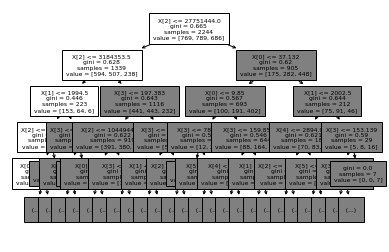

In [126]:
tree.plot_tree(clf, max_depth= 4, fontsize= 6)

The results are quite better than the regression case.

##### We try to compare our classifiers with a classifier that chooses randomly the class. 2364 training samples, 592 testing samples.

In [127]:
np.random.seed(5)

y_pred_train = np.random.randint(0,3,size=2244)
print('train accuracy: ', accuracy_score(y_train, y_pred_train))

y_pred_test = np.random.randint(0,3,size=562)
print('test accuracy: ', accuracy_score(y_test, y_pred_test))

train accuracy:  0.339572192513369
test accuracy:  0.3185053380782918


In [128]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_test)

array([[64, 66, 70],
       [64, 65, 51],
       [71, 61, 50]])

# Some conclusions

Let's check the importance of the features considered to explain the phenomenon.

In [129]:
print('Coefficients: ')
print(coefficients)

Coefficients: 
SP.DYN.CBRT.IN        4.932860
Year                 12.940231
Population           16.388321
Density               2.139197
TerritoryDefense     -0.696271
PopulationDefense    -5.555010
dtype: float64


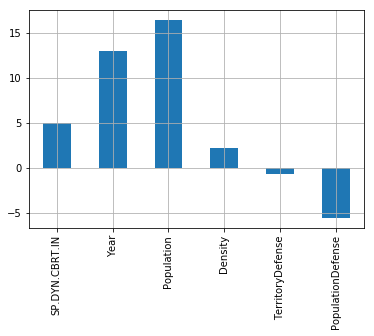

In [130]:
coefficients.plot(kind="bar").grid()

As we expected from the preliminary analysis, in the last years terroristic attacks have increased; in particoular, from this plot we can also confirm that the <strong>Year</strong> has an important role in this scenario. <br><br>
More evident is the influence of <strong>SP.URB.TOTL</strong>, an index about the Urban Population: the more it is, the more the attacks. <br>
On the other hand, we have a strong negative influence from the <strong>PopulationDefense</strong> feature; reasonably, the more the defense, the less the number of attacks.<br>
We'll go deeper in detail in these 2 directions.

Very relevant are also the results that we can interpret from the <strong>decision tree</strong>, since we obtained better performances approaching the problem from a classification point of view.

In [131]:
from sklearn.tree import export_text

data = df_class.loc[:, df_std.columns != 'cnt']
data_features = list(data.columns.values)
r = export_text(clf, feature_names= data_features)
print(r)

|--- Population <= 27751444.00
|   |--- Population <= 3184353.50
|   |   |--- Year <= 1994.50
|   |   |   |--- Population <= 2867248.00
|   |   |   |   |--- SP.DYN.CBRT.IN <= 29.10
|   |   |   |   |   |--- Density <= 195.40
|   |   |   |   |   |   |--- Density <= 75.23
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Density >  75.23
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- Density >  195.40
|   |   |   |   |   |   |--- Density <= 1086.40
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Density >  1086.40
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- SP.DYN.CBRT.IN >  29.10
|   |   |   |   |   |--- Density <= 1.71
|   |   |   |   |   |   |--- Year <= 1981.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Year >  1981.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- Density >  1.71
|   |   |   |   |   |   |--- Density <= 26.91
|   |   |   |   | 

As before, the most important feature which determines the number of attacks is the <strong>Urban Population</strong>; in particoular, we can see that under a certain threshold the class predicted is 0 or 1 (a little or some attacks), while over the threshold the classes 1 and 2 (some or many attacks) are predominant.<br>
Same goes for the <strong>Year</strong>: after the 2000s the classes 1 and 2 are the big majority (and the other way around), so again we confirmed that in latest years the terroris activity has increased.<br>
About the <strong>Population Defense</strong>, we can see again that it is not as impactful as the two previous features, but it has its not neglectable influence: for example, where we have a high Urban Population, the few cases in which we have a predicted class of 0 or 1, they are usually characterized by a high (or simply not upper bounded) value of Population Defense.<br><br>

We'll now analyze deeper in detail there 3 features.

Mean of all features and output <strong>from 1990 (included) until 2018</strong>, for every country.

In [237]:
df = pd.read_csv('./part/DF1sthypTOT')
df['TerritoryDefense'] = df['MilitaryExp'] / df['Area (sq. mi.)']
df['PopulationDefense'] = df['MS.MIL.MPRT.KD'] / df['Population']
del df['Area (sq. mi.)']
del df['SP.RUR.TOTL']
del df['SP.URB.TOTL']
del df['SP.DYN.AMRT.FE']
del df['SP.DYN.AMRT.MA']
del df['SP.DYN.LE00.IN']
del df['MilitaryExp']
del df['MS.MIL.MPRT.KD']

df2 = df[df['Year']>1989]
df3 = df2.groupby(['CountryCode', 'Year']).mean()
df4.head(5)

,SP.DYN.CBRT.IN,Population,Density,cnt,TerritoryDefense,PopulationDefense
CountryCode,,,,,,
ABW,14.075208,71891.0,465.811744,0.000000,1.167154e+08,20190.302938
AFG,45.270125,31056997.0,33.027058,246.750000,2.043345e+04,31.097411
AGO,50.182292,12127071.0,13.182071,17.750000,1.342397e+03,30.439836
ALB,17.924417,3581655.0,106.830482,2.916667,6.861392e+04,304.666177
ARE,16.529375,2602713.0,53.154304,0.250000,1.638169e+05,305.066290


Let's take a look to the <strong>global mean</strong> for the Urban Population and the Population Defense.<br>
<i>Reminder:</i> the calculus is performed on the last 30 years.

In [238]:
df5 = df4[['Population', 'PopulationDefense']]
#df5.mean()
df5.median()

Population           8.250692e+06
PopulationDefense    7.954754e+01
dtype: float64

Now let's check the features of the top 10 attacked countries, focusing in particoular on <strong>Population</strong> and <strong>PopulationDefense</strong> columns.

In [239]:
df4.sort_values(['cnt'], ascending=False).head(10)

,SP.DYN.CBRT.IN,Population,Density,cnt,TerritoryDefense,PopulationDefense
CountryCode,,,,,,
IRQ,34.994208,2.678338e+07,56.862475,503.750000,33044.828923,35.994821
PAK,32.975792,1.658036e+08,178.040131,382.416667,5344.640696,4.505080
IND,25.751458,1.095352e+09,328.143591,290.541667,6576.190834,1.841075
AFG,45.270125,3.105700e+07,33.027058,246.750000,20433.452767,31.097411
COL,20.693250,4.359304e+07,36.114905,180.958333,4390.780180,2.738396
PHL,28.514000,8.946868e+07,267.063261,134.333333,5582.879591,1.688674
DZA,23.665167,3.293009e+07,13.382202,111.958333,1375.437107,14.218252
THA,14.426667,6.463160e+07,122.528914,105.833333,6324.666811,4.076309
TUR,20.983083,7.041396e+07,82.680395,92.875000,14077.276988,16.395897


We can see that the Population for these countries is usually higher than the average, while the Population Defense is heavily lower. <br>
Let's take a graphical view some of the top attacked countries: 
- Philippines
- Pakistan
- India 
- Afghanistan 
- Colombia

Let's start from the <strong>Population</strong> (where the red line is the mean value).

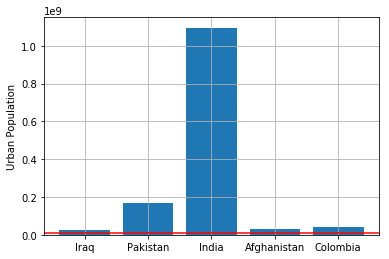

In [240]:
import matplotlib.pyplot as plt

pop_def = []
m_value = df5['Population'].median()
plt.axhline(y=m_value, color='r', linestyle='-', label='Mean')
y = df4['Population']
pop_def.append(y.loc['IRQ'])
pop_def.append(y.loc['PAK'])
pop_def.append(y.loc['IND'])
pop_def.append(y.loc['AFG'])
pop_def.append(y.loc['COL'])
plt.bar([1,2,3,4,5],pop_def, tick_label=['Iraq', 'Pakistan', 'India', 'Afghanistan', 'Colombia'])
plt.ylabel('Urban Population')
plt.grid()
plt.show()

<i>As we can see, the reasoning doesn't apply to some exceptions, like war zones such as Afghanistan</i>

Now let's take a look to the <strong>Population Defense</strong>.

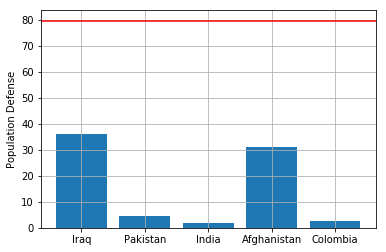

In [241]:
import matplotlib.pyplot as plt

pop_def = []
m_value = df5['PopulationDefense'].median()
plt.axhline(y=m_value, color='r', linestyle='-', label='Mean')
y = df4['PopulationDefense']
pop_def.append(y.loc['IRQ'])
pop_def.append(y.loc['PAK'])
pop_def.append(y.loc['IND'])
pop_def.append(y.loc['AFG'])
pop_def.append(y.loc['COL'])
plt.bar([1,2,3,4,5],pop_def, tick_label=['Iraq', 'Pakistan', 'India', 'Afghanistan', 'Colombia'])
plt.ylabel('Population Defense')
plt.grid()
plt.show()

<strong>Conclusion</strong>:<br>
We have just checked for these 5 countries that the number of terroristic attack is the highest in the latest years; also, they all have in common a high numer of Urban Population (except to Afghanistan), together with a very low Population Defense.<br>
About the Year, we have shown in different ways that lately (about from 2000 onward) the terrorism activity has increased.

In [242]:
high = df4[df4['cnt'] > 14]  #mean belonging to class 2
high.sort_values(['PopulationDefense'], ascending=True).head(10)

,SP.DYN.CBRT.IN,Population,Density,cnt,TerritoryDefense,PopulationDefense
CountryCode,,,,,,
IDN,22.119417,2.454527e+08,112.599375,26.541667,1478.440858,0.936195
NGA,42.497833,1.318597e+08,140.766521,63.791667,1029.306039,1.626256
BGD,26.861458,1.473654e+08,926.917765,34.333333,6175.431626,1.641047
PHL,28.514000,8.946868e+07,267.063261,134.333333,5582.879591,1.688674
IND,25.751458,1.095352e+09,328.143591,290.541667,6576.190834,1.841075
USA,14.500000,2.984442e+08,29.162471,28.428571,40967.108544,2.150198
FRA,12.900000,6.087614e+07,112.801570,53.347826,89142.802749,2.181907
COL,20.693250,4.359304e+07,36.114905,180.958333,4390.780180,2.738396
DEU,9.127273,8.242230e+07,229.072461,26.409091,107337.676088,3.724169


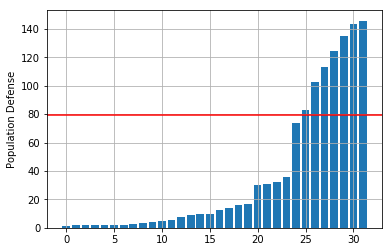

In [243]:
import matplotlib.pyplot as plt

pop_def = []
m_value = df4['PopulationDefense'].median()
plt.axhline(y=m_value, color='r', linestyle='-', label='Median')
y = high['PopulationDefense']
axis = []
for i, country in enumerate(high.index):
    pop_def.append(y.loc[country])
    axis.append(i)

pop_def.sort()
plt.bar(axis,pop_def)
plt.ylabel('Population Defense')
plt.grid()
plt.show()

In [259]:
low = df4[df4['cnt'] < 1]  #mean belonging to class 0
low.sort_values(['PopulationDefense'], ascending=False).head(10)

,SP.DYN.CBRT.IN,Population,Density,cnt,TerritoryDefense,PopulationDefense
CountryCode,,,,,,
GRL,16.650000,56361.0,0.025940,0.000000,1.039943e+04,25753.642918
ABW,14.075208,71891.0,465.811744,0.000000,1.167154e+08,20190.302938
SYC,18.100000,81541.0,191.863736,0.000000,1.901363e+04,17800.874021
GRD,20.929958,89703.0,295.823038,0.000000,6.548276e+07,16181.187569
KIR,31.453958,105432.0,108.715783,0.000000,2.777567e+07,13195.916395
TON,28.566917,114689.0,132.809325,0.000000,3.011506e+07,11078.337373
GUM,21.077125,171019.0,281.795518,0.000000,4.163783e+07,8487.367301
WSM,30.143250,176908.0,59.955786,0.000000,7.651518e+06,8204.835669
VUT,31.456250,208869.0,16.056933,0.083333,1.846399e+06,6949.336994


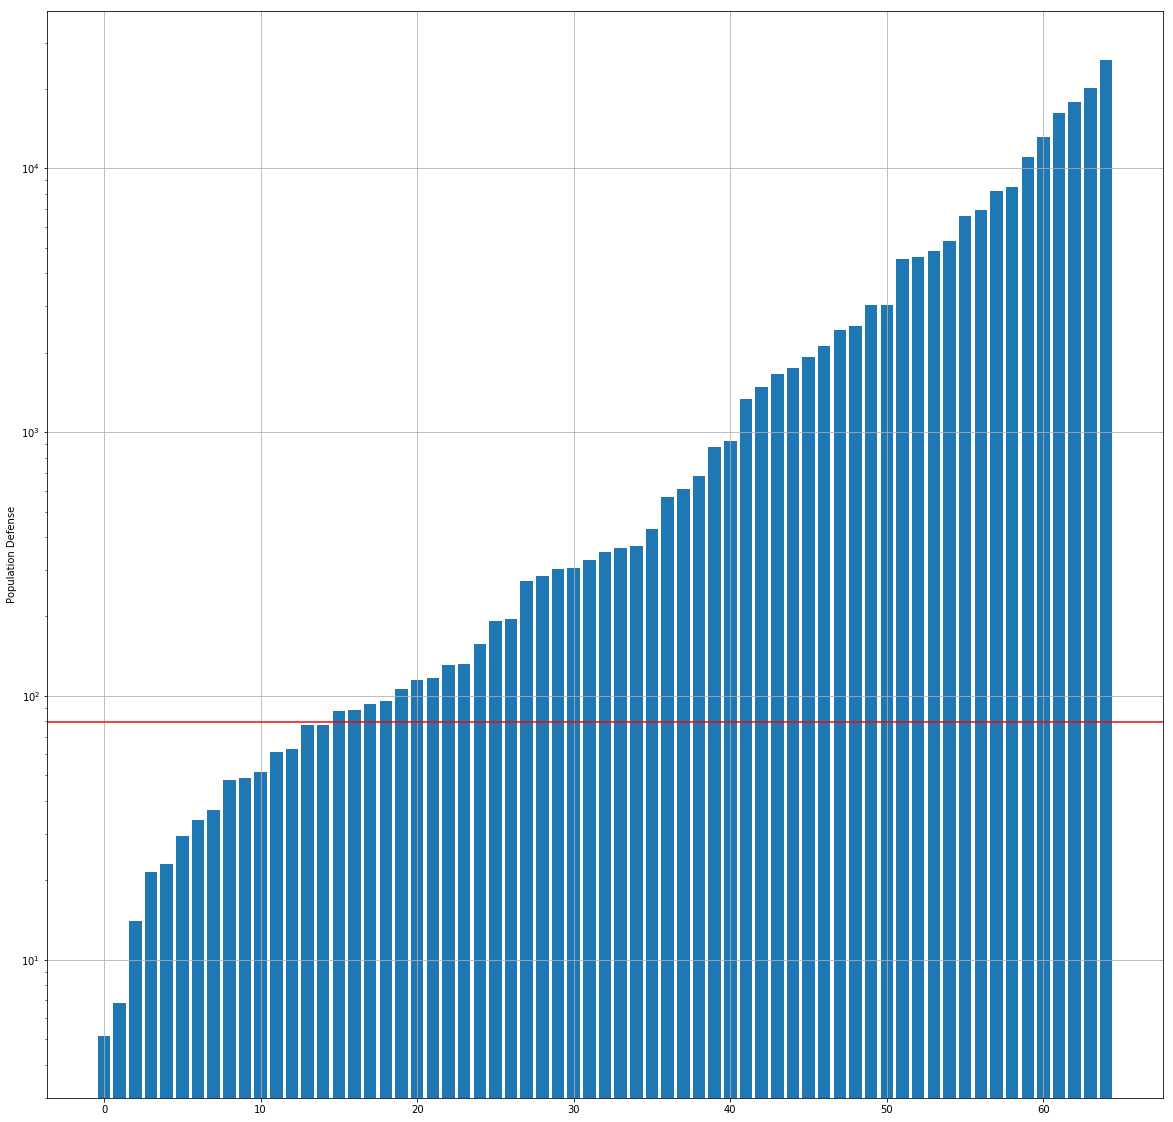

In [257]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20, 20))
ax.set_yscale('log')

pop_def = []
m_value = df4['PopulationDefense'].median()
plt.axhline(y=m_value, color='r', linestyle='-', label='Median')
y = low['PopulationDefense']
axis = []
for i, country in enumerate(low.index):
    pop_def.append(y.loc[country])
    axis.append(i)

pop_def.sort()
plt.bar(axis, pop_def)
plt.ylabel('Population Defense')
plt.grid()
plt.show()

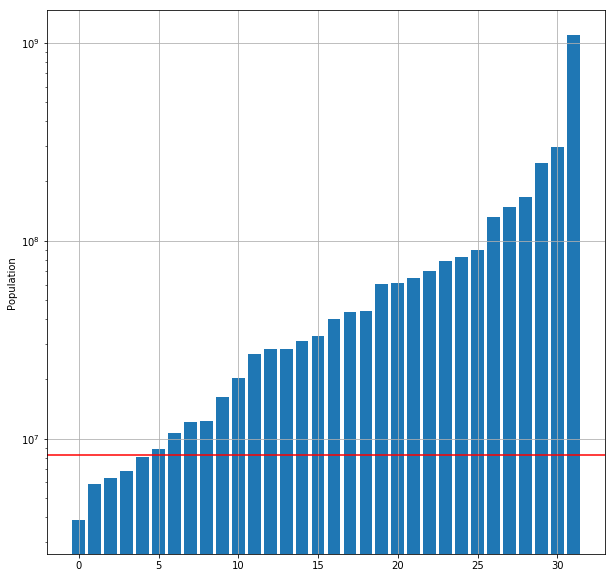

In [251]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
ax.set_yscale('log')

pop_def = []
m_value = df4['Population'].median()
plt.axhline(y=m_value, color='r', linestyle='-', label='Median')
y = high['Population']
axis = []
for i, country in enumerate(high.index):
    pop_def.append(y.loc[country])
    axis.append(i)

pop_def.sort()
plt.bar(axis, pop_def)
plt.ylabel('Population')
plt.grid()
plt.show()

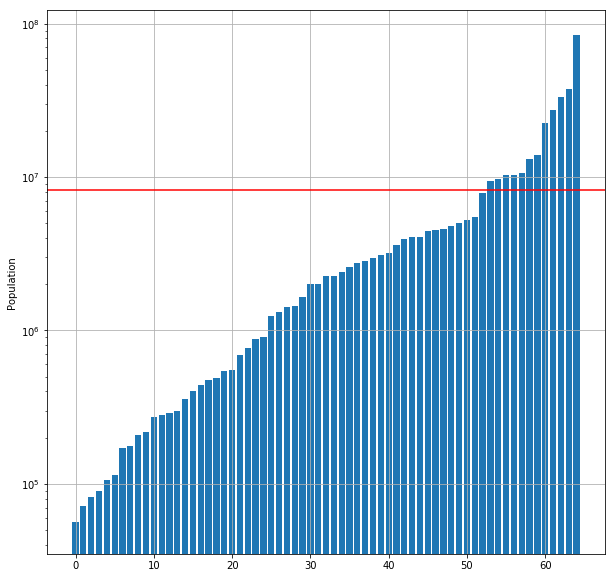

In [254]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
ax.set_yscale('log')

pop_def = []
m_value = df4['Population'].median()
plt.axhline(y=m_value, color='r', linestyle='-', label='Median')
y = low['Population']
axis = []
for i, country in enumerate(low.index):
    pop_def.append(y.loc[country])
    axis.append(i)

pop_def.sort()
plt.bar(axis, pop_def)
plt.ylabel('Population')
plt.grid()
plt.show()

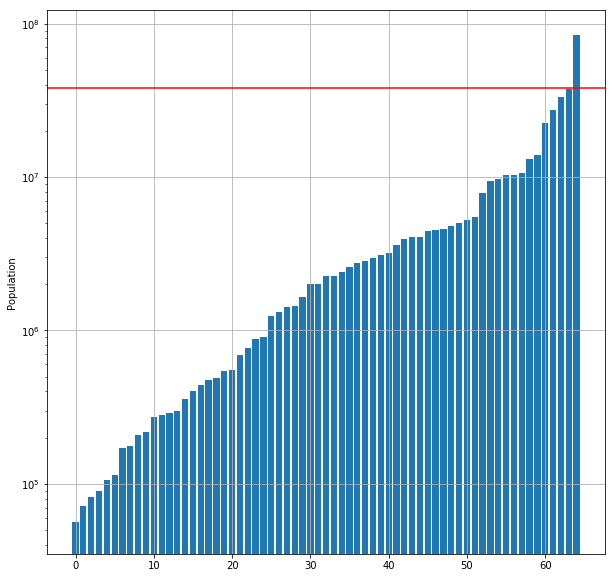

In [256]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
ax.set_yscale('log')

pop_def = []
m_value = df4['Population'].mean()
plt.axhline(y=m_value, color='r', linestyle='-', label='Median')
y = low['Population']
axis = []
for i, country in enumerate(low.index):
    pop_def.append(y.loc[country])
    axis.append(i)

pop_def.sort()
plt.bar(axis, pop_def)
plt.ylabel('Population')
plt.grid()
plt.show()